<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Test-vacc-strategy" data-toc-modified-id="Test-vacc-strategy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test vacc strategy</a></span></li><li><span><a href="#Scenarios-S(trict)" data-toc-modified-id="Scenarios-S(trict)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scenarios S(trict)</a></span><ul class="toc-item"><li><span><a href="#Scenario-..." data-toc-modified-id="Scenario-...-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Scenario ...</a></span></li><li><span><a href="#Figures-lockdown-case-S" data-toc-modified-id="Figures-lockdown-case-S-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Figures lockdown-case S</a></span></li></ul></li><li><span><a href="#Scenarios-F(ree)" data-toc-modified-id="Scenarios-F(ree)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scenarios F(ree)</a></span><ul class="toc-item"><li><span><a href="#Scenario-..." data-toc-modified-id="Scenario-...-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Scenario ...</a></span></li><li><span><a href="#Figures-free-case-F" data-toc-modified-id="Figures-free-case-F-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Figures free-case F</a></span></li><li><span><a href="#Age-group-figures" data-toc-modified-id="Age-group-figures-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Age-group figures</a></span></li></ul></li><li><span><a href="#Scenario-A:-contact-level-pre-pandemic" data-toc-modified-id="Scenario-A:-contact-level-pre-pandemic-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scenario A: contact level pre-pandemic</a></span><ul class="toc-item"><li><span><a href="#Scenario-A4:-Vaccination-old-to-young,-eff=0.9" data-toc-modified-id="Scenario-A4:-Vaccination-old-to-young,-eff=0.9-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Scenario A4: Vaccination old to young, eff=0.9</a></span></li><li><span><a href="#Scenario-A5:-First-the-most-mobile,-eff=0.9" data-toc-modified-id="Scenario-A5:-First-the-most-mobile,-eff=0.9-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Scenario A5: First the most mobile, eff=0.9</a></span></li><li><span><a href="#Figures-case-A" data-toc-modified-id="Figures-case-A-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Figures case A</a></span></li></ul></li><li><span><a href="#Scenario-C:-comix-August" data-toc-modified-id="Scenario-C:-comix-August-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scenario C: comix August</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save data</a></span></li><li><span><a href="#Plot-saved-data" data-toc-modified-id="Plot-saved-data-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot saved data</a></span></li><li><span><a href="#Fast-plotting" data-toc-modified-id="Fast-plotting-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Fast plotting</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random
from math import floor

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot

plt.rcParams.update({'font.size': 12, 'axes.grid':True, 'grid.linewidth':0.3})
pd.plotting.register_matplotlib_converters()

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cum'] = df_sciensano.D_tot.cumsum()

In [5]:
df_google = mobility.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [6]:
# Load samples dictionary of the first wave
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-26_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_sept = json.load(fp) 

In [ ]:
# fig,ax = plt.subplots()
# pd.Series(samples_dict['beta']).hist()
# pd.Series(samples_dict['tau']).hist()

## Settings

In [7]:
UL = 0.975
LL = 0.025

In [8]:
start_calibration = '2021-01-01'
#end_calibration = '2020-11-12'
end_sim = '2021-08-01'

In [9]:
# for figures
start_x = start_calibration
end_x = '2021-03-15'
end_grid = '2021-02-15'
# n=5
# label_0 = 'no prior vaccination'
# label_10 = 'low prior vaccination'
# label_30 = 'medium prior vaccination'
# label_50 = 'high prior vaccination'

Alle vaccins twee dosissen nodig (Pfizer, Moderna, AstraZeneca, Curevac) behalve Johnson&Johnson (pas vanaf mei)

In [10]:
# doses per day (Regeringscommissariaat Corona, published by De Tijd)
d = {}
d['jan'] = 31765
d['feb'] = 45897
d['mar-apr'] = 128499
d['may-aug'] = 78358

# proportion of age group living in nursing homes
# for simplicity we will use the data for respectively age groups 60+, 70+ and 80+
NH = {}
NH['65+'] = 0.007
NH['75+'] = (0.05+0.029)/2
NH['85+'] = (0.137+0.267)/2


# Functions

In [11]:
def vacc_strategy(t, param, d, NH):
    """
    time-dependent function for vaccination strategy
    
    d : dictionary
        daily number of doses for that month
    NH : dictionary
        proportion of residents in nursing homes per age group
    
    """
    
    N_vacc = np.array([0.0]*9)
    delay = pd.Timedelta('30D')
    
    t1 = pd.Timestamp('2021-01-01') + delay
    t2 = pd.Timestamp('2021-02-01') + delay
    t3 = pd.Timestamp('2021-03-01') + delay
    t4 = pd.Timestamp('2021-05-01') + delay
    
    if t < t1:
        N_vacc = np.array([0.0]*9)
    
    elif t1 <= t < t2: # January : nursing homes + part of care personnel
        # daily vaccinated persons on immunity date = daily dose on vaccination date / 2
        daily_85 = (NH['85+']*initN[8])/31
        daily_75 = (NH['75+']*initN[7])/31
        daily_65 = (NH['65+']*initN[6])/31
        care_personnel_daily_jan = d['jan']/2-daily_85-daily_75-daily_65
        N_vacc[8] = daily_85
        N_vacc[7] = daily_75
        N_vacc[6] = daily_65
        N_vacc[[5,4,3,2]] = care_personnel_daily_jan/4
        
    elif t2 <= t < t3: # February : care personnel
        N_vacc[[5,4,3,2]] = d['feb']/2/4
        
    elif t3 <= t < t4: # March-April : 65+ and risico patients
        plus_65_left_daily = ((1-NH['85+'])*initN[8] + (1-NH['75+'])*initN[7] + (1-NH['65+'])*initN[6])/60
        rest_daily = d['mar-apr']/2 - plus_65_left_daily
        N_vacc[[8,7,6]] = plus_65_left_daily/3
        N_vacc[[5,4,3,2]] = rest_daily/4
    
    else: # May-August : all 18+
        N_vacc[[5,4,3,2]] = d['may-aug']/2/4
        
    return N_vacc
    
    

In [12]:
def vaccin_model(effectivity, initial_states, tdep_fun=None, levels=levels):
    """
    Function to initialize the model given a certain vaccination strategy
    """
    params = model_parameters.get_COVID19_SEIRD_parameters()

    params.update({'d' : d,
                   'NH' : NH,
                   'e' : np.array([effectivity]*levels),
                  })
    
    if tdep_fun is not None:
        tdp = {'Nc': tdep_fun,'N_vacc':vacc_strategy}
    else:
        tdp = {'N_vacc':vacc_strategy}
    return models.COVID19_SEIRD(initial_states, params, time_dependent_parameters=tdp)

In [ ]:
def plot_band(ax, y_model, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sum(dim="Nc"), 
                    y_model[var].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sum(dim="Nc"), color=color, label=label, lw=2)
    return

In [ ]:
def plot_band_saved_data(ax, df, mean_col, LL_col, UL_col, color, label):
    ax.fill_between(df['time'],df[LL_col], df[UL_col],alpha=0.30, facecolor = color)
    ax.plot(df['time'], df[mean_col], color=color, label=label, lw=2)
    return

In [ ]:
def plot_band_age(ax, y_model, age_group, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sel(Nc=age_group), 
                    y_model[var].quantile(UL,dim="draws").sel(Nc=age_group),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sel(Nc=age_group), color=color, label=label, lw=2)
    return

# Test vacc strategy

In [13]:
initial_states = {'S': initN, 'E': np.ones(levels)}

In [14]:
params = model_parameters.get_COVID19_SEIRD_parameters()
dummy_model_no_vacc = models.COVID19_SEIRD(initial_states, params)
sim_dummy_model_no_vacc = dummy_model_no_vacc.sim(time=end_sim, start_date=start_calibration)

In [15]:
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              })
dummy_model_vacc = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
# dummy_model_vacc = vaccin_model(effectivity=0.9, initial_states=initial_states)
# sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [16]:
timerange = pd.date_range(start_calibration,end_sim)
test_dict = {}
for t in timerange:
    test_dict[t] = np.sum(vacc_strategy(t=t, param=None, d=d, NH=NH))
test_df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
test_df.columns = ['date','N_vacc']

<IPython.core.display.Javascript object>


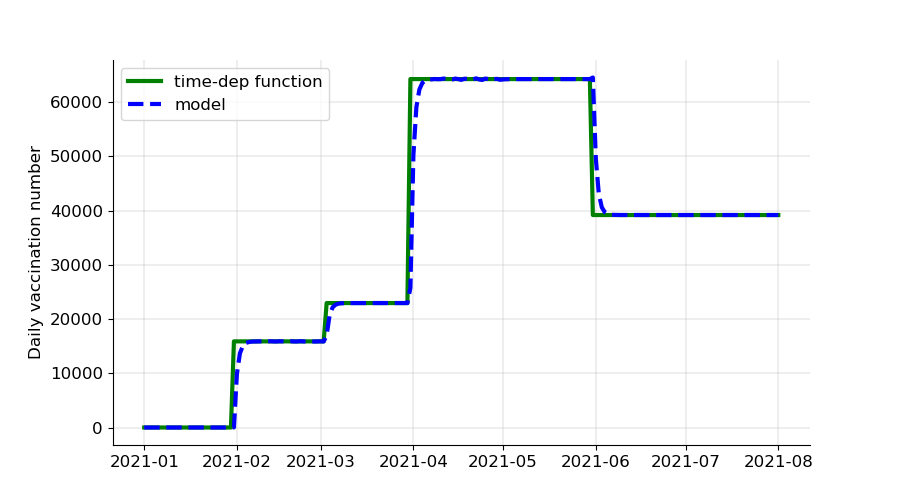

Text(0, 0.5, 'Daily vaccination number')

In [19]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot('date', 'N_vacc', data=test_df, c='green', label='time-dep function')
ax.plot(sim_dummy_model_vacc['time'], sim_dummy_model_vacc['V_new'].sum(dim='Nc'), c='blue', linestyle='--', label='model')
ax.legend()
ax.set_ylabel('Daily vaccination number')

In [20]:
N = d['jan']/2*31+d['feb']/2*28+d['mar-apr']/2*(31+30)+d['may-aug']/2*(31+30)
print('Approximate total number of vaccinations by august 1: {}'.format(N))
#pd.to_datetime(end_sim) - pd.to_datetime(start_calibration)
V_pool_aug = sim_dummy_model_vacc['V'].sum(dim='Nc').values[-1]
print('Number of persons in vaccinated pool by end of simulation: {}'.format(V_pool_aug))
V_new_sum = sim_dummy_model_vacc['V_new'].sum(dim='Nc').sum(dim='time').values
print('Total number of people vaccinated by end of simulation: {}'.format(V_new_sum))

Approximate total number of vaccinations by august 1: 7444054.0
Number of persons in vaccinated pool by end of simulation: 7260943.031813024
Total number of people vaccinated by end of simulation: 7468154.781040039


<IPython.core.display.Javascript object>


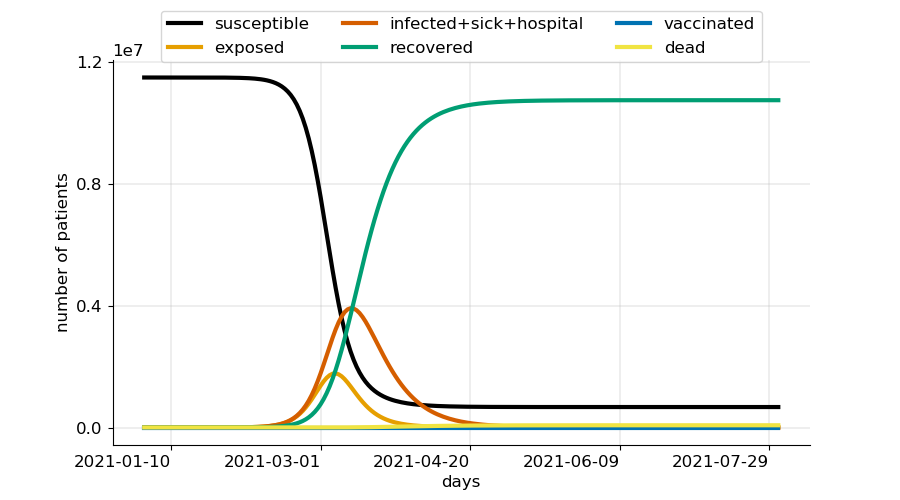

In [24]:
population_status(sim_dummy_model_no_vacc)

<IPython.core.display.Javascript object>


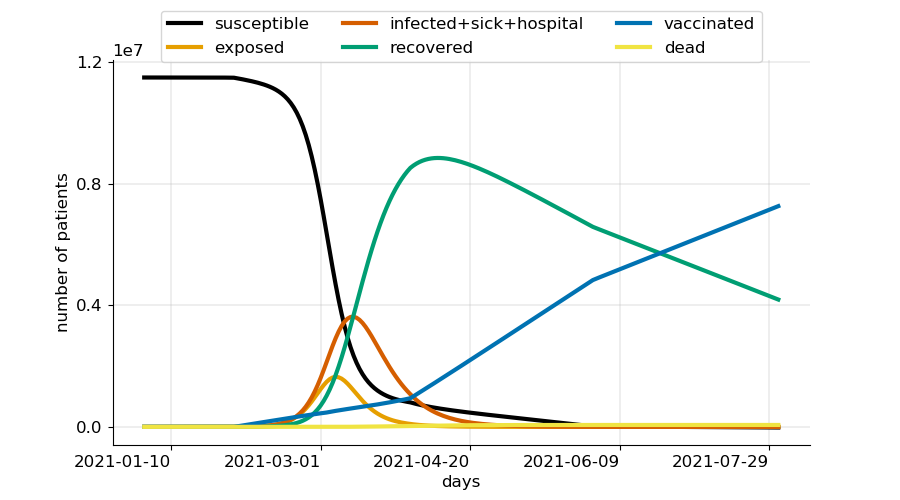

In [23]:
population_status(sim_dummy_model_vacc)

# Scenarios S(trict)

In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()


In [ ]:
np.size(params['Nc'])

In [ ]:
initN

In [ ]:
# Initialize the model
model_S1 = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'Nc': google_lockdown})

In [ ]:

# fig,ax=plt.subplots(figsize=(10,4))
# for i in range(5):
#     # Sampling
#     model_S1.parameters['beta'] = np.random.choice(samples_dict['beta'])
#     idx,model_S1.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#     model_S1.parameters['tau'] = samples_dict['tau'][idx]   
#     # Simulate
#     plot_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0)
#     # Plot
#     ax.plot(plot_model_S1['time'],plot_model_S1["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

# ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

# #ax = _apply_tick_locator(ax)
# ax.set_xlim(start_x,end_sim)

In [ ]:
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

## Scenario ...

In [ ]:
order = [8,7,6,5,4,3,2,1,0]
effectivity = 0.7
daily=10000

In [ ]:
vaccinated_prop = 0
model_S2a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=google_lockdown)
vaccinated_prop = 0.1
model_S2b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=google_lockdown)
vaccinated_prop = 0.3
model_S2c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=google_lockdown)
vaccinated_prop = 0.5
model_S2d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=google_lockdown)

In [ ]:
y_model_S2a = model_S2a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2b = model_S2b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2c = model_S2c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S2d = model_S2d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
# fig,ax = plt.subplots()
# y_model_S1['E'].sum(dim='Nc'). plot(ax=ax, c='green', label='no vacc')
# y_model_S2a['E'].sum(dim='Nc'). plot(ax=ax, c='blue', label='S2a')
# plt.legend()

## Figures lockdown-case S

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax3, y_model_S4a, 'H_in', 'C0', label_0)
plot_band(ax3, y_model_S4b, 'H_in', 'C1', label_10)
plot_band(ax3, y_model_S4c, 'H_in', 'C2', label_30)
plot_band(ax3, y_model_S4d, 'H_in', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
plot_band(ax4, y_model_S5a, 'H_in', 'C0', label_0)
plot_band(ax4, y_model_S5b, 'H_in', 'C1', label_10)
plot_band(ax4, y_model_S5c, 'H_in', 'C2', label_30)
plot_band(ax4, y_model_S5d, 'H_in', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
N_days = int((pd.to_datetime(end_grid) - pd.to_datetime(start_x))/pd.Timedelta('1D'))
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
#ax4.set_xticklabels(np.arange(0,N_days,step=30))
ax4.set_yticklabels('')

ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')

# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)
ax3.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')

#fig.savefig('../../results/vaccinations/national/vaccination_wave2_hosp_current_measures.pdf')

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_S1, 'D', 'gray', 'no vaccination')
plot_band(ax3, y_model_S4a, 'D', 'C0', label_0)
plot_band(ax3, y_model_S4b, 'D', 'C1', label_10)
plot_band(ax3, y_model_S4c, 'D', 'C2', label_30)
plot_band(ax3, y_model_S4d, 'D', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_S1, 'D', 'gray', 'no vaccination')
plot_band(ax4, y_model_S5a, 'D', 'C0', label_0)
plot_band(ax4, y_model_S5b, 'D', 'C1', label_10)
plot_band(ax4, y_model_S5c, 'D', 'C2', label_30)
plot_band(ax4, y_model_S5d, 'D', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
N_days = int((pd.to_datetime(end_grid) - pd.to_datetime(start_x))/pd.Timedelta('1D'))
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
#ax4.set_xticklabels(np.arange(0,N_days,step=30))
ax4.set_yticklabels('')

ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')

# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)

ax3.set_ylim(0,8000)
fig.text(0, 0.5, 'Cumulative number of deaths', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../../results/vaccinations/national/vaccination_wave2_deaths_current_measures.pdf')

# Scenarios F(ree)

In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
              'Nc_15min' : Nc_15min,
              'Nc_1hr' : Nc_1hr,
               'l' : 5,
               'tau' : 5,
               'prevention':0.5
              })

In [ ]:
# Initialize the model
model_F1 = models.COVID19_SEIRD(initial_states_sept, params, time_dependent_parameters={'Nc': no_lockdown})

In [ ]:

# fig,ax=plt.subplots(figsize=(10,4))
# for i in range(1):
#     # Sampling
#     model_F1.parameters['beta'] = np.random.choice(samples_dict['beta'])
#     idx,model_F1.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
#     model_F1.parameters['tau'] = samples_dict['tau'][idx]   
#     # Simulate
#     plot_model_F1 = model_F1.sim(end_sim,start_date=start_calibration,warmup=0)
#     # Plot
#     ax.plot(plot_model_F1['time'],plot_model_F1["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

# ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

# ax.set_xlim('2020-09-01',end_sim)

## Scenario ...

In [ ]:
order = [8,7,6,5,4,3,2,1,0]
effectivity = 0.7
daily=10000

In [ ]:
vaccinated_prop = 0
model_F2a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=no_lockdown)
vaccinated_prop = 0.1
model_F2b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=no_lockdown)
vaccinated_prop = 0.3
model_F2c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=no_lockdown)
vaccinated_prop = 0.5
model_F2d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept, tdep_fun=no_lockdown)

In [ ]:
y_model_F2a = model_F2a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_F2b = model_F2b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_F2c = model_F2c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_F2d = model_F2d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)
y_model_F1 = model_F1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
# fig,ax = plt.subplots()
# y_model_F1['E'].sum(dim='Nc').sum(dim='draws'). plot(ax=ax, c='green', label='no vacc')
# y_model_F2a['E'].sum(dim='Nc').sum(dim='draws'). plot(ax=ax, c='blue', label='S2a')
# plt.legend()

## Figures free-case F

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_F1, 'H_in', 'gray', 'no vaccination')
plot_band(ax3, y_model_F4a, 'H_in', 'C0', label_0)
plot_band(ax3, y_model_F4b, 'H_in', 'C1', label_10)
plot_band(ax3, y_model_F4c, 'H_in', 'C2', label_30)
plot_band(ax3, y_model_F4d, 'H_in', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_F1, 'H_in', 'gray', 'no vaccination')
plot_band(ax4, y_model_F5a, 'H_in', 'C0', label_0)
plot_band(ax4, y_model_F5b, 'H_in', 'C1', label_10)
plot_band(ax4, y_model_F5c, 'H_in', 'C2', label_30)
plot_band(ax4, y_model_F5d, 'H_in', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
N_days = int((pd.to_datetime(end_grid) - pd.to_datetime(start_x))/pd.Timedelta('1D'))
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
#ax4.set_xticklabels(np.arange(0,N_days,step=30))
ax4.set_yticklabels('')

ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')

# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)

#ax1.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../../results/vaccinations/national/vaccination_wave2_hosp_no_measures.pdf')

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

# ax3.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_F1, 'D', 'gray', 'no vaccination')
plot_band(ax3, y_model_F4a, 'D', 'C0', label_0)
plot_band(ax3, y_model_F4b, 'D', 'C1', label_10)
plot_band(ax3, y_model_F4c, 'D', 'C2', label_30)
plot_band(ax3, y_model_F4d, 'D', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

# ax4.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_F1, 'D', 'gray', 'no vaccination')
plot_band(ax4, y_model_F5a, 'D', 'C0', label_0)
plot_band(ax4, y_model_F5b, 'D', 'C1', label_10)
plot_band(ax4, y_model_F5c, 'D', 'C2', label_30)
plot_band(ax4, y_model_F5d, 'D', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
N_days = int((pd.to_datetime(end_grid) - pd.to_datetime(start_x))/pd.Timedelta('1D'))
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
#ax4.set_xticklabels(np.arange(0,N_days,step=30))
ax4.set_yticklabels('')

ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')

# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)
ax3.set_ylim(0,23000)
fig.text(0, 0.5, 'Cumulative number of deaths', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../../results/vaccinations/national/vaccination_wave2_deaths_no_measures.pdf')

## Age-group figures

In [ ]:
age_group = 8
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True, sharey=True)
# ax1.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax1, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax1, y_model_F2a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax1, y_model_F2b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax1, y_model_F2c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax1, y_model_F2d, age_group, 'D', 'C3', '50% at start')

ax1.set_xlim(start_x, end_x)
ax1.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.set_title('Vaccination according to age \n 70% effectivity')


# ax2.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax2, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax2, y_model_F3a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax2, y_model_F3b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax2, y_model_F3c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax2, y_model_F3d, age_group, 'D', 'C3', '50% at start')

ax2.set_xlim(start_x, end_x)
ax2.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax2.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.set_title('Vaccination according to number of contacts \n 70% effectivity')


# ax3.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax3, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax3, y_model_F4a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax3, y_model_F4b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax3, y_model_F4c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax3, y_model_F4d, age_group, 'D', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('90% effectivity')

# ax4.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax4, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax4, y_model_F5a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax4, y_model_F5b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax4, y_model_F5c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax4, y_model_F5d, age_group, 'D', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('90% effectivity')


ax1.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax1.set_ylim(0,22500)
fig.text(0, 0.5, 'Cumulative number of deaths', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


#fig.savefig('../../results/vaccinations/national/vaccination_wave2_deaths_no_measures_age80+.pdf')

In [ ]:
age_group = 5
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(figsize=(10,10), nrows=2, ncols=2, sharex=True, sharey=True)
# ax1.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax1, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax1, y_model_F2a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax1, y_model_F2b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax1, y_model_F2c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax1, y_model_F2d, age_group, 'D', 'C3', '50% at start')

ax1.set_xlim(start_x, end_x)
ax1.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.set_title('Vaccination according to age \n 70% effectivity')


# ax2.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax2, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax2, y_model_F3a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax2, y_model_F3b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax2, y_model_F3c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax2, y_model_F3d, age_group, 'D', 'C3', '50% at start')

ax2.set_xlim(start_x, end_x)
ax2.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax2.xaxis.set_tick_params(which='both', labelbottom=True)
ax2.set_title('Vaccination according to number of contacts \n 70% effectivity')


# ax3.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax3, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax3, y_model_F4a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax3, y_model_F4b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax3, y_model_F4c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax3, y_model_F4d, age_group, 'D', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('90% effectivity')

# ax4.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_age(ax4, y_model_F1, age_group, 'D', 'gray', 'no vaccination')
plot_band_age(ax4, y_model_F5a, age_group, 'D', 'C0', '0% at start')
plot_band_age(ax4, y_model_F5b, age_group, 'D', 'C1', '10% at start')
plot_band_age(ax4, y_model_F5c, age_group, 'D', 'C2', '30% at start')
plot_band_age(ax4, y_model_F5d, age_group, 'D', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('90% effectivity')


ax1.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax1.set_ylim(0,2500)
fig.text(0, 0.5, 'Cumulative number of deaths', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


#fig.savefig('../../results/vaccinations/national/vaccination_wave2_deaths_no_measures_age50-60.pdf')

# Scenario A: contact level pre-pandemic

In [ ]:
# Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

In [ ]:
# Initialize the model
model_A1 = models.COVID19_SEIRD(initial_states_sept, params)

In [ ]:

# fig,ax=plt.subplots(figsize=(10,4))
# for i in range(5):
#     # Sampling
#     #model_A1.parameters['beta'] = np.random.choice(samples_dict['beta'])
#     # Simulate
#     y_model_A1 = model_A1.sim(end_sim,start_date=start_calibration,warmup=0)
#     # Plot
#     ax.plot(y_model_A1['time'],y_model_A1["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

# ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

# ax.set_xlim('2020-09-01',end_sim)

In [ ]:
n=5

In [ ]:
y_model_A1 = model_A1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)

## Scenario A4: Vaccination old to young, eff=0.9

In [ ]:
order = [8,7,6,5,4,3,2,1,0]
effectivity = 0.9
daily=10000

In [ ]:
vaccinated_prop = 0
model_A4a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_A4b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_A4c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_A4d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [ ]:
y_model_A4a = model_A4a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A4b = model_A4b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A4c = model_A4c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A4d = model_A4d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)

## Scenario A5: First the most mobile, eff=0.9

In [ ]:
order = [2,3,4,5,6,7,8,1,0]
effectivity = 0.9
daily=10000

In [ ]:
vaccinated_prop = 0
model_A5a = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.1
model_A5b = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.3
model_A5c = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)
vaccinated_prop = 0.5
model_A5d = vaccin_model(vaccinated_prop, order, daily, effectivity, initial_states_sept)

In [ ]:
y_model_A5a = model_A5a.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A5b = model_A5b.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A5c = model_A5c.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)
y_model_A5d = model_A5d.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=None,samples=samples_dict)

## Figures case A

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_A1, 'H_in', 'gray', 'no vaccination')
plot_band(ax3, y_model_A4a, 'H_in', 'C0', label_0)
plot_band(ax3, y_model_A4b, 'H_in', 'C1', label_10)
plot_band(ax3, y_model_A4c, 'H_in', 'C2', label_30)
plot_band(ax3, y_model_A4d, 'H_in', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_A1, 'H_in', 'gray', 'no vaccination')
plot_band(ax4, y_model_A5a, 'H_in', 'C0', label_0)
plot_band(ax4, y_model_A5b, 'H_in', 'C1', label_10)
plot_band(ax4, y_model_A5c, 'H_in', 'C2', label_30)
plot_band(ax4, y_model_A5d, 'H_in', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')
ax4.set_yticklabels('')


# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)

#ax1.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../../results/vaccinations/national/vaccination_hosp_prelockdown.pdf')

In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

# ax3.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax3, y_model_A1, 'D', 'gray', 'no vaccination')
plot_band(ax3, y_model_A4a, 'D', 'C0', label_0)
plot_band(ax3, y_model_A4b, 'D', 'C1', label_10)
plot_band(ax3, y_model_A4c, 'D', 'C2', label_30)
plot_band(ax3, y_model_A4d, 'D', 'C3', label_50)

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

# ax4.plot('DATE','D_cum',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
#          c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band(ax4, y_model_A1, 'D', 'gray', 'no vaccination')
plot_band(ax4, y_model_A5a, 'D', 'C0', label_0)
plot_band(ax4, y_model_A5b, 'D', 'C1', label_10)
plot_band(ax4, y_model_A5c, 'D', 'C2', label_30)
plot_band(ax4, y_model_A5d, 'D', 'C3', label_50)

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')
ax4.set_yticklabels('')


# Shrink current axis by 20%
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width, box.height*0.8])
box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height*0.8])

ax3.legend(loc='upper center', bbox_to_anchor=(1,1.4), ncol=3)

#ax3.set_ylim(0,22500)
fig.text(0, 0.5, 'Cumulative number of deaths', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


fig.savefig('../../results/vaccinations/national/vaccination_wave2_deaths_prelockdown.pdf')

# Save data

In [ ]:
S_results_H_in = pd.DataFrame()
S_results_H_in['time'] =  y_model_S1['time']
var = 'H_in'
for x in ['S1', 'S4a', 'S4b', 'S4c', 'S4d', 'S5a', 'S5b', 'S5c', 'S5d']:
    mod = eval('y_model_'+x)
    S_results_H_in[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    S_results_H_in[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    S_results_H_in[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
S_results_H_in.to_csv('../../results/vaccinations/national/S_results_H_in.csv', index=None)

In [ ]:
S_results_D = pd.DataFrame()
S_results_D['time'] =  y_model_S1['time']
var = 'D'
for x in ['S1', 'S4a', 'S4b', 'S4c', 'S4d', 'S5a', 'S5b', 'S5c', 'S5d']:
    mod = eval('y_model_'+x)
    S_results_D[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    S_results_D[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    S_results_D[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
S_results_D.to_csv('../../results/vaccinations/national/S_results_D.csv', index=None)

In [ ]:
F_results_H_in = pd.DataFrame()
F_results_H_in['time'] =  y_model_F1['time']
var = 'H_in'
for x in ['F1', 'F4a', 'F4b', 'F4c', 'F4d', 'F5a', 'F5b', 'F5c', 'F5d']:
    mod = eval('y_model_'+x)
    F_results_H_in[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    F_results_H_in[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    F_results_H_in[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
F_results_H_in.to_csv('../../results/vaccinations/national/F_results_H_in.csv', index=None)

In [ ]:
F_results_D = pd.DataFrame()
F_results_D['time'] =  y_model_F1['time']
var = 'D'
for x in ['F1', 'F4a', 'F4b', 'F4c', 'F4d', 'F5a', 'F5b', 'F5c', 'F5d']:
    mod = eval('y_model_'+x)
    F_results_D[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    F_results_D[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    F_results_D[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
F_results_D.to_csv('../../results/vaccinations/national/F_results_D.csv', index=None)

# Plot saved data

In [ ]:
S_results_H_in = pd.read_csv('../../results/vaccinations/national/S_results_H_in.csv', parse_dates=['time'])

In [ ]:
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')


In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')

# plot_band(ax3, y_model_S4a, 'H_in', 'C0', '0% at start')
# plot_band(ax3, y_model_S4b, 'H_in', 'C1', '10% at start')
# plot_band(ax3, y_model_S4c, 'H_in', 'C2', '30% at start')
# plot_band(ax3, y_model_S4d, 'H_in', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
# plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
# plot_band(ax4, y_model_S5a, 'H_in', 'C0', '0% at start')
# plot_band(ax4, y_model_S5b, 'H_in', 'C1', '10% at start')
# plot_band(ax4, y_model_S5c, 'H_in', 'C2', '30% at start')
# plot_band(ax4, y_model_S5d, 'H_in', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')


ax3.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax3.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')


# Fast plotting

In [ ]:
end_sim = '2021-01-01'

fig,ax=plt.subplots(figsize=(10,4))
model_S2c.parameters['beta'] = np.mean(samples_dict['beta'])
model_S2c.parameters['l'] = np.mean(samples_dict['l'])
model_S2c.parameters['tau'] = np.mean(samples_dict['tau'])
y_model_S2c = model_S2c.sim(end_sim,start_date=start_calibration,warmup=0)

ax.plot(y_model_S2c['time'],y_model_S2c["H_in"].sum(dim="Nc"),color='blue',alpha=1)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')

#ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)

In [ ]:
    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-09-01') # start vaccination 80+
    t2 = t1 + pd.Timedelta(floor(initN[8]/daily), unit='D')

In [ ]:
n=100
y_model_S1 = model_S1.sim(end_sim,start_date=start_calibration,warmup=0,N=n,
                          draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

In [ ]:
fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_in"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_in"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_in"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_in'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Number of new hospitalizations')
ax = _apply_tick_locator(ax)

In [ ]:

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model_S1['time'].values),y_model_S1["H_tot"].quantile(LL,dim="draws").sum(dim="Nc"), y_model_S1["H_tot"].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.20, color = 'blue')
ax.plot(y_model_S1['time'],y_model_S1["H_tot"].mean(dim="draws").sum(dim="Nc"),'--', color='blue')
ax.scatter(df_sciensano[start_calibration:end_sim].index,df_sciensano['H_tot'][start_calibration:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')

ax.set_ylabel('Total patients in Belgian hospitals')
ax = _apply_tick_locator(ax)

In [ ]:
for t in times:
    v = vacc_policy_old_to_young(t, initN, daily=10000)
    print(v)